In [1]:
import fastText
import train_embeddings
import sentence_features
import pickle
from random import shuffle
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [10]:
# Load mapped reports
labeled_reports_path = "../data/processed/processed_reports/preprocessed_all_replace_sw"
mapped_reports = pickle.load(open(labeled_reports_path, 'rb'))

In [11]:
# Convert mapped reports to correct format
mapped_report_strs = []
for mr in mapped_reports:
    report_string = " ".join(mr[0]).replace("\n", " ")
    label = " __label__" + str(mr[1])
    mapped_report_strs.append(report_string + label)
shuffle(mapped_report_strs)

In [25]:
split_point = int(0.9 * len(mapped_report_strs))
train = mapped_report_strs[:split_point]
test = mapped_report_strs[split_point:]

test_data = [t.split("__label__")[0] for t in test]
test_labels = [int(t.split("__label__")[1]) for t in test]

train_path = "../data/processed/processed_reports/ftTRAIN"
with open(train_path, 'w') as outfile:
    for mrs in train:
        outfile.write(mrs)
        outfile.write("\n")

In [26]:
# Train classifier
dim = 120
ng = 3
model = fastText.train_supervised(train_path, dim=dim, epoch=12, thread=4, neg=8, lr=0.05, wordNgrams=ng)

In [27]:
model.get_words()

['right',
 'left',
 'unremarkable',
 'normal',
 '</s>',
 'RISK',
 'within',
 'SCREEN',
 'small',
 'mild',
 'NEGEX_evidence',
 'unchanged',
 'soft',
 'bilateral',
 'measuring',
 'lower',
 'lobe',
 'prior',
 'seen',
 'size',
 'tissues',
 'visualized',
 'upper',
 'fluid',
 'likely',
 'posterior',
 'interval',
 'lung',
 'measures',
 'post',
 'mass',
 'image',
 'anterior',
 'bones',
 'spine',
 'liver',
 'artery',
 'NEGEX_acute',
 'vein',
 'disease',
 'lesion',
 'changes',
 'series',
 'ct',
 'compared',
 'PT',
 'gallbladder',
 'findings',
 'lateral',
 'new',
 'patent',
 'status',
 'pulmonary',
 'pain',
 'chest',
 'increased',
 'collection',
 'fracture',
 'tissue',
 'none',
 'pleural',
 'inferior',
 'HX',
 'lungs',
 'NEGEX_suspicious',
 'bowel',
 'noted',
 'moderate',
 'distal',
 'age',
 'abdomen',
 'kidneys',
 'vertebral',
 'edema',
 'represent',
 'multiple',
 'renal',
 'disc',
 'bladder',
 'hepatic',
 'joint',
 'flow',
 'pancreas',
 'appearance',
 'tube',
 'enhancement',
 'signal',
 'weeks'

In [28]:
# Make predictions
predictions = [model.predict(s) for s in test_data]
confs = [0.5 - (p[1][0] / 2) if p[0][0] == '__label__0' else 0.5 + (p[1][0] / 2) for p in predictions]

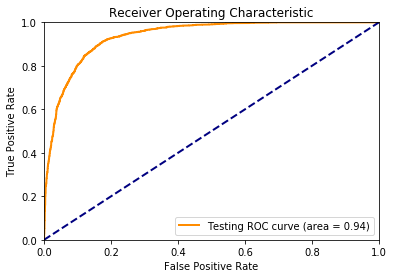

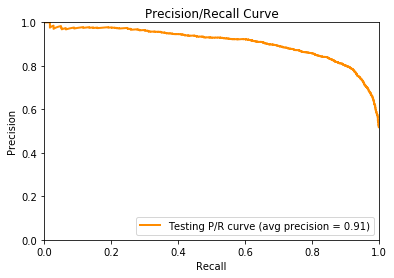

Precision at .9 recall: 0.80
[0.7586829048263419, 0.7584105084105084, 0.758468863209314, 0.7585272443474553, 0.7585856518427697, 0.7586440857131103, 0.7587025459763461, 0.7587610326503628, 0.7588195457530618, 0.7588780853023609, 0.7589366513161939, 0.7589952438125114, 0.7590538628092793, 0.7591125083244805, 0.759171180376114, 0.7592298789821949, 0.7592886041607547, 0.7593473559298415, 0.7594061343075194, 0.7594649393118688, 0.7595237709609868, 0.7595826292729869, 0.7596415142659988, 0.7597004259581687, 0.7597593643676592, 0.7598183295126497, 0.7598773214113358, 0.7599363400819296, 0.7599953855426598, 0.7600544578117717, 0.7601135569075272, 0.7601726828482047, 0.7602318356520992, 0.7602910153375224, 0.7603502219228025, 0.7604094554262848, 0.7604687158663306, 0.7605280032613184, 0.7605873176296435, 0.7606466589897174, 0.760706027359969, 0.7607654227588434, 0.7608248452048029, 0.7608842947163266, 0.76094377131191, 0.7610032750100661, 0.7610628058293245, 0.7611223637882314, 0.7611819489053

In [31]:
fpr, tpr, thresholds = roc_curve(test_labels, confs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(test_labels, confs)
avg_prec = average_precision_score(test_labels, confs)

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='Testing P/R curve (avg precision = %0.2f)' % avg_prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()

r90_index = [i for i, r in enumerate(recall) if r > .9][-1]
p_at_r90 = precision[r90_index]
print('Precision at .9 recall: %0.2f' % p_at_r90)
f1 = [(recall[i] + precision[i]) / 2 for i in range(len(recall))]
f1 = max(f1)
print('F1 score:  %0.2f' % f1)

In [19]:
model_name = "ft" + str(dim) + "_" + str(ng) + ("_%0.2f" % roc_auc) + ".bin"
model.save_model("../data/models/fastText/classify/" + model_name)

In [10]:
epochs = [1, 2, 3] + list(range(5, 10, 5))

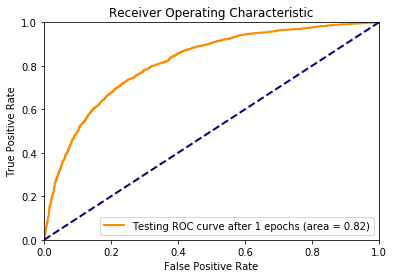

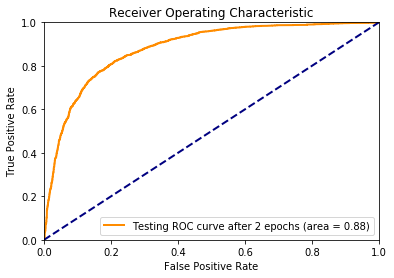

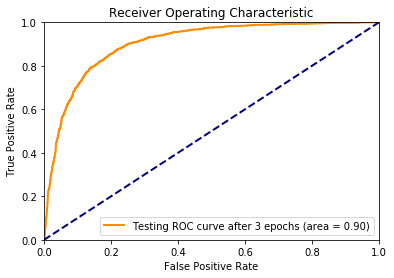

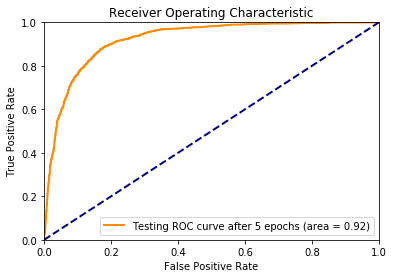

In [11]:
for e in epochs:
    model = fastText.train_supervised(train_path, dim=300, epoch=e, thread=4, neg=8, lr=0.05, wordNgrams=3)
    predictions = [model.predict(s) for s in test_data]
    confs = [1 - p[1][0] if p[0][0] == '__label__0' else p[1][0] for p in predictions]
    
    fpr, tpr, thresholds = roc_curve(test_labels, confs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Testing ROC curve after ' + str(e) + ' epochs (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
# Look at what words give high outputs
test_words = model.get_words()
predictions = [model.predict(s) for s in test_words]
score_pairs = zip(test_words, predictions)
print(predictions[0])
for word, score in score_pairs:
    if score[1][0] < .8:
        print(word + ": " + str(score))

(('__label__0',), array([0.68421161]))
right: (('__label__0',), array([0.68421161]))
small: (('__label__0',), array([0.78098786]))
bilateral: (('__label__0',), array([0.61585009]))
tissues: (('__label__1',), array([0.51207691]))
ct: (('__label__0',), array([0.56550008]))
upper: (('__label__0',), array([0.74132985]))
likely: (('__label__1',), array([0.68588543]))
abdomen: (('__label__1',), array([0.64943516]))
cervical: (('__label__0',), array([0.76961499]))
hepatic: (('__label__0',), array([0.60349119]))
appearance: (('__label__1',), array([0.58574301]))
weeks: (('__label__1',), array([0.78331947]))
pancreas: (('__label__1',), array([0.79671282]))
signal: (('__label__1',), array([0.59155947]))
mri: (('__label__1',), array([0.53535414]))
severe: (('__label__0',), array([0.5552699]))
abdominal: (('__label__1',), array([0.71667606]))
femoral: (('__label__0',), array([0.57074982]))
consistent: (('__label__1',), array([0.7635451]))
proximal: (('__label__1',), array([0.76516873]))
pelvis: ((

earlier: (('__label__0',), array([0.67009914]))
sylvian: (('__label__0',), array([0.64992446]))
dictation: (('__label__0',), array([0.597767]))
cross: (('__label__0',), array([0.72382432]))
towards: (('__label__1',), array([0.70653123]))
NEGEX_pneumatosis: (('__label__0',), array([0.58427465]))
term: (('__label__0',), array([0.75867689]))
globe: (('__label__1',), array([0.53461927]))
NEGEX_articular: (('__label__0',), array([0.60724509]))
patency: (('__label__0',), array([0.73364782]))
questionable: (('__label__0',), array([0.62359822]))
gastroesophageal: (('__label__1',), array([0.54141951]))
ulcer: (('__label__0',), array([0.65854168]))
NEGEX_occlusion: (('__label__0',), array([0.51377314]))
mechanism: (('__label__0',), array([0.78912777]))
metabolic: (('__label__0',), array([0.74261039]))
discitis: (('__label__0',), array([0.53762931]))
therefore: (('__label__0',), array([0.78577113]))
equina: (('__label__0',), array([0.53117687]))
NEGEX_surrounding: (('__label__0',), array([0.67837

ards: (('__label__0',), array([0.7926268]))
NEGEX_tolerate: (('__label__0',), array([0.76920849]))
NEGEX_septic: (('__label__0',), array([0.72169536]))
pcas: (('__label__0',), array([0.79753304]))
distributions: (('__label__0',), array([0.7873593]))
delineate: (('__label__0',), array([0.77979952]))
NEGEX_disruption: (('__label__0',), array([0.78137207]))
microlithiasis: (('__label__0',), array([0.57653862]))
adhesion: (('__label__0',), array([0.74365401]))
NEGEX_particularly: (('__label__0',), array([0.78249395]))
bloc: (('__label__0',), array([0.72695184]))
extravasated: (('__label__0',), array([0.76514173]))
NEGEX_gastric: (('__label__0',), array([0.76851195]))
pseudo: (('__label__0',), array([0.79269135]))
gastrojejunal: (('__label__0',), array([0.71361393]))
opacifications: (('__label__0',), array([0.73435366]))
delineation: (('__label__0',), array([0.79183108]))
aspirate: (('__label__0',), array([0.78128725]))
accounts: (('__label__0',), array([0.79546595]))
NEGEX_transformation: 